# A model for determining the cost of cars.

### Description of the project
The "Not Beaten, Not Crashed" used car sales service is developing an application to attract new customers. It will be possible to find out the market value of one's car. We will build a model that can determine it. We have data on the technical characteristics, equipment and prices of other cars. 

Criteria that are important to the customer: 
* quality of prediction; 
* training time of the model; 
* prediction time of the model.

### Main steps:
1. Load the data.
2. Explore the data. Fill in missing values and process anomalies in columns. If there are uninformative features among them, remove them.
3. Prepare samples for model training.
4. Train different models, one of which is LightGBM, at least one is not boosting. Try different hyperparameters for each model.
5. Analyze the training time, prediction time and model quality.
6. Based on the customer's criteria, select the best model and check its quality on the test sample.

## Contents:
1. Reviewing of the data, preprocessing and EDA.
2. Encoding data.
3. Training models.
4. Model analysis.
5. Testing models.
6. Overall conclusion.

### Description of data:
#### Features:
* DateCrawled - date of downloading the profile from the database
* VehicleType - type of car body
* RegistrationYear - year of car registration
* Gearbox - type of transmission
* Power - power (hp)
* Model - car model
* Kilometer - mileage (km)
* RegistrationMonth - month of car registration
* FuelType - type of fuel
* Brand - car brand
* NotRepaired - was the car in repair or not
* DateCreated - date of profile creation
* NumberOfPictures - number of car photos
* PostalCode - postal code of the profile owner (user)
* LastSeen - date of last user activity

#### Target feature: 
* Price - Euros

## 1. Reviewing of the data, preprocessing and EDA.

In [1]:
! pip install catboost
! pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import time

In [3]:
pd.set_option('display.max_columns', 50)
pd.options.display.float_format = '{:,.2f}'.format

Let's load the dataset.

In [4]:
url = 'https://code.s3.yandex.net/datasets/autos.csv'
data = pd.read_csv(url)

Let's take a look at the data.

In [5]:
data.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


Let's check for duplicates.

In [6]:
print('Number of dublicates:', data.duplicated().sum())

Number of dublicates: 4


In [7]:
data.drop_duplicates(inplace=True)
data.reset_index(drop=True).head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

Let's transform the column names to lowercase with underscores.

In [8]:
data.set_axis(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 
             'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 
             'not_repaired', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'],
              axis='columns',
              inplace=True)
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354365 non-null  object
 1   price               354365 non-null  int64 
 2   vehicle_type        316875 non-null  object
 3   registration_year   354365 non-null  int64 
 4   gearbox             334532 non-null  object
 5   power               354365 non-null  int64 
 6   model               334660 non-null  object
 7   kilometer           354365 non-null  int64 
 8   registration_month  354365 non-null  int64 
 9   fuel_type           321470 non-null  object
 10  brand               354365 non-null  object
 11  not_repaired        283211 non-null  object
 12  date_created        354365 non-null  object
 13  number_of_pictures  354365 non-null  int64 
 14  postal_code         354365 non-null  int64 
 15  last_seen           354365 non-null  object
dtypes:

In the dataset, there are uninformative columns such as: 
* date_crawled - the date the profile was downloaded from the database, 
* registration_month - the month the car was registered, 
* date_created - the date the profile was created, 
* number_of_pictures - the number of photos of the car, 
* postal_code - the postal code of the profile owner (user)
* last_seen - the date of the user's last activity.

Delete it.

In [10]:
data = data[['vehicle_type',
             'gearbox', 
             'power',
             'kilometer',
             'fuel_type',
             'brand',
             'not_repaired',
             'registration_year',
             'model',
             'price']]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       316875 non-null  object
 1   gearbox            334532 non-null  object
 2   power              354365 non-null  int64 
 3   kilometer          354365 non-null  int64 
 4   fuel_type          321470 non-null  object
 5   brand              354365 non-null  object
 6   not_repaired       283211 non-null  object
 7   registration_year  354365 non-null  int64 
 8   model              334660 non-null  object
 9   price              354365 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [11]:
data.describe()

,power,kilometer,registration_year,price
count,"354,365.00","354,365.00","354,365.00","354,365.00"
mean,110.09,"128,211.36","2,004.23","4,416.68"
std,189.85,"37,905.08",90.23,"4,514.18"
min,0.00,"5,000.00","1,000.00",0.00
25%,69.00,"125,000.00","1,999.00","1,050.00"
50%,105.00,"150,000.00","2,003.00","2,700.00"
75%,143.00,"150,000.00","2,008.00","6,400.00"
max,"20,000.00","150,000.00","9,999.00","20,000.00"


We can see both missing data and obvious anomalies. 

Power: 0 - 20,000 horsepower; 

Registration year: 1000 - 9999; 

Price: zero values.

Let's look at the missing data.

In [12]:
print('----- NaN values -----')
nans_info = pd.DataFrame()
nans_info['Number of NaN'] = data.isnull().sum()
nans_info['% NaN'] = (nans_info['Number of NaN'] / data.shape[0] * 100).round(2)

nans_info = nans_info.sort_values(by='Number of NaN', 
                                  ascending=False)
nans_info

----- NaN values -----


,Number of NaN,% NaN
not_repaired,71154,20.08
vehicle_type,37490,10.58
fuel_type,32895,9.28
gearbox,19833,5.60
model,19705,5.56
power,0,0.00
kilometer,0,0.00
brand,0,0.00
registration_year,0,0.00
price,0,0.00


Let's look at the not_repaired column.

In [13]:
data['not_repaired'].value_counts()

no     247158
yes     36053
Name: not_repaired, dtype: int64

As we can see, this column contains categorical values with missing values, replacing it with the mean is not possible, deleting 20% of the data is not possible. Let's replace NaN with unknown.

In [14]:
data['not_repaired'] = data['not_repaired'].fillna('unknown')

Next.

In [15]:
data['vehicle_type'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

As we can see, this column contains categorical values with missing values, replacing it with the mean is not possible, deleting 10% of the data is not possible. Let's replace NaN with unknown.

In [16]:
data['vehicle_type'] = data['vehicle_type'].fillna('unknown')

Next.

In [17]:
data['fuel_type'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

Besides the missing values, we see the anomaly of petrol and gasoline, which is gasoline, let's combine the data under one category of petrol.

In [18]:
data['fuel_type'] = np.where(data['fuel_type'] == 'gasoline', 
                             'petrol', 
                             data['fuel_type'])

data['fuel_type'].fillna('unknown', 
                         inplace=True)

Next.

In [19]:
data['gearbox'].value_counts()

manual    268249
auto       66283
Name: gearbox, dtype: int64

In [20]:
data['model'].value_counts()

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

Let's replace the missing values with unknown.

In [21]:
data['gearbox'] = data['gearbox'].fillna('unknown')
data['model'] = data['model'].fillna('unknown')

Посмотрим на результат.

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       354365 non-null  object
 1   gearbox            354365 non-null  object
 2   power              354365 non-null  int64 
 3   kilometer          354365 non-null  int64 
 4   fuel_type          354365 non-null  object
 5   brand              354365 non-null  object
 6   not_repaired       354365 non-null  object
 7   registration_year  354365 non-null  int64 
 8   model              354365 non-null  object
 9   price              354365 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


The missing values in the categorical data are filled. Let's look at the remaining data.

### Anomalies and errors in the price column - the price.

In [23]:
sns.set(style="darkgrid")

def draw_boxplot(df, column, title, 
                 figsize=(16,6), color='red', 
                 xlabel='', xlim=None):
  
    plt.figure(figsize=figsize)

    ax = sns.boxplot(x=df[column], 
                     color=color)

    if (xlim != None):
        plt.xlim(xlim)

    ax.set(xlabel=xlabel, 
           title=title)
        
def draw_histogram(df, column, title, 
                   figsize=(16,6), color='red',
                   xlabel='', ylabel='', kde=False,
                   bins=None, xticks=0, xlim=None, ylim=None):
  
    plt.figure(figsize=figsize)

    ax = sns.distplot(df[column], 
                      color=color, 
                      kde=kde, 
                      bins=bins)

    if (xlim != None):
        plt.xlim(xlim)
    if (ylim != None):
        plt.ylim(ylim)

    ax.set(xlabel=xlabel, 
           ylabel=ylabel, 
           title=title)

    if xticks != 0:
        ax.set(xticks=xticks)

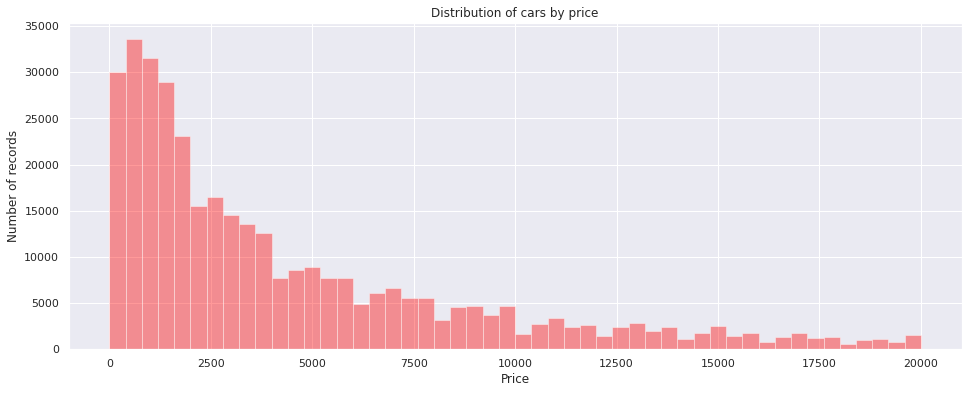

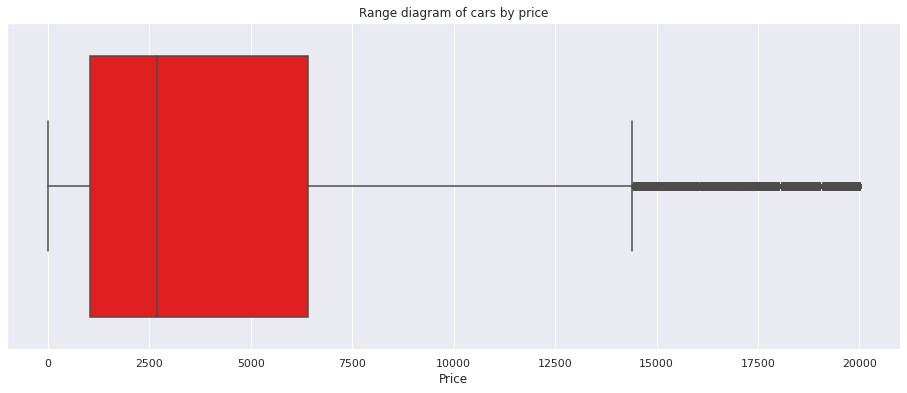

In [24]:
draw_histogram(data, 
               'price', 
               'Distribution of cars by price', 
               xlabel='Price', 
               ylabel='Number of records')

draw_boxplot(data, 
             'price', 
             'Range diagram of cars by price', 
             xlabel='Price')

Let's look on the data closer by price up to 2500 eur.

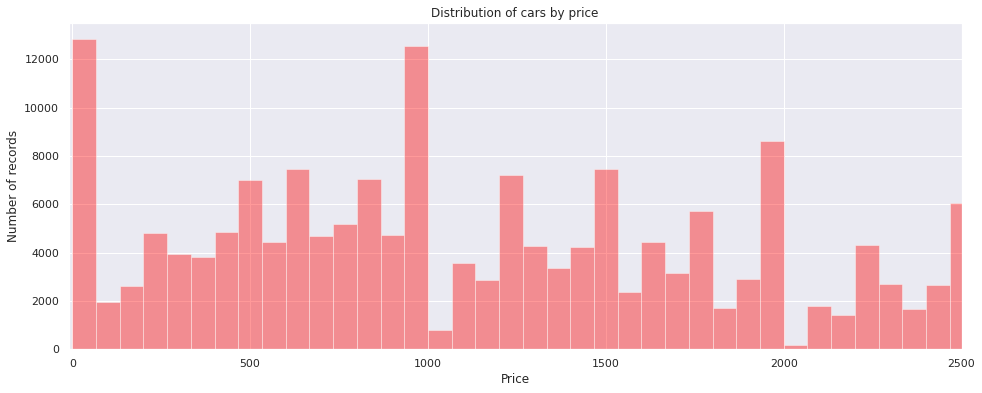

In [25]:
draw_histogram(data, 
               'price', 
               'Distribution of cars by price', 
               xlabel='Price', 
               ylabel='Number of records', 
               xlim=(-10, 2500), 
               bins=300)

We see an anomalous peak in the vicinity of zero.

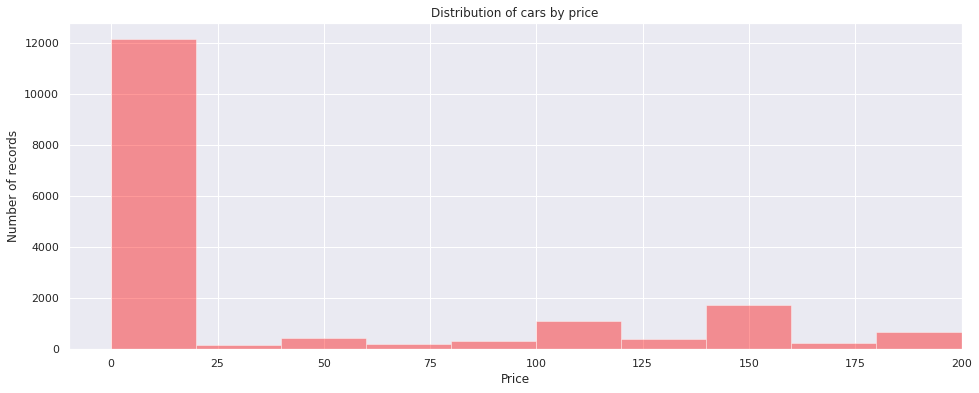

In [26]:
draw_histogram(data, 
               'price', 
               'Distribution of cars by price', 
               xlabel='Price', 
               ylabel='Number of records', 
               xlim=(-10, 200), 
               bins=1000)

We see anomalous data. Let's see how many data with zero price.

In [27]:
print('Number of zero data:', data.query('price == 0').shape[0])
print('% of zero data:', round(((data.query('price == 0').shape[0] / len(data) ) *100), 2))

Number of zero data: 10772
% of zero data: 3.04


Let's delete the zero values.

In [28]:
data = data.query('price != 0')
data.reset_index(drop=True).head()

print('Number of zero data:', data.query('price == 0').shape[0])
print('% of zero data:', round(((data.query('price == 0').shape[0] / len(data) ) *100), 2))

Number of zero data: 0
% of zero data: 0.0


### Anomalies and errors in the registration_year column - the year of registration.

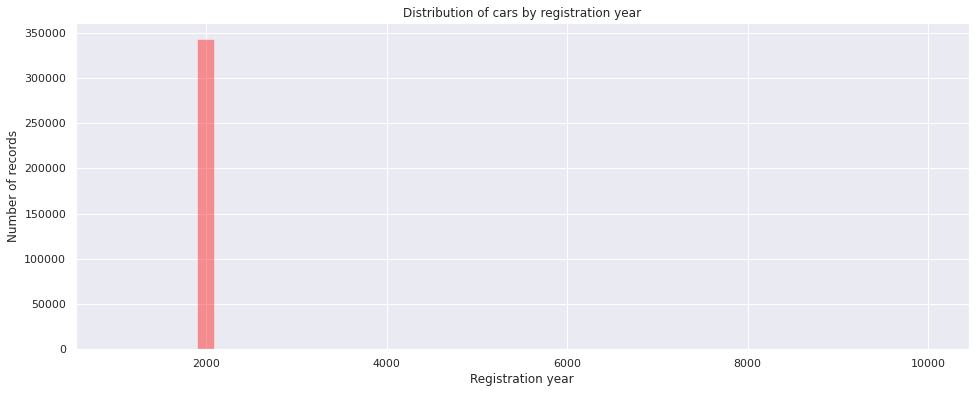

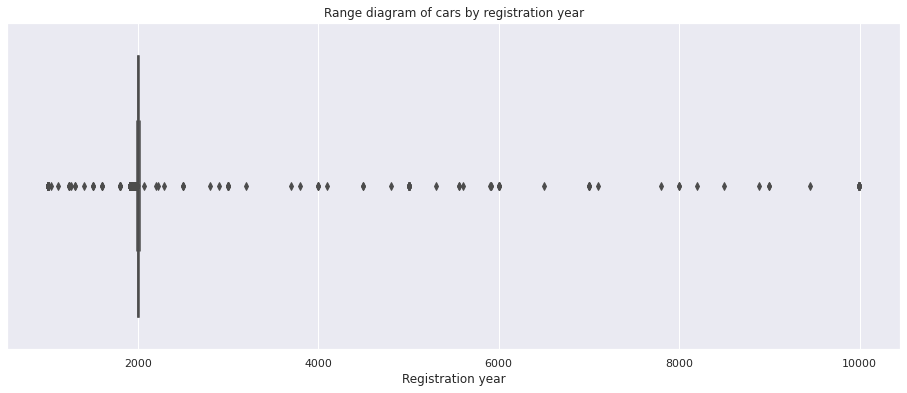

In [29]:
draw_histogram(data, 
               'registration_year', 
               'Distribution of cars by registration year', 
               xlabel='Registration year', 
               ylabel='Number of records')

draw_boxplot(data, 
             'registration_year', 
             'Range diagram of cars by registration year', 
             xlabel='Registration year')

We can see that the main volume of cars was registered at the end of the 1900s - beginning of the 2000s.

Let's look at the outliers of the range diagram to determine an adequate period of car registration.

In [30]:
def span_charts(column):
    stat = data[column].describe()
    quantile = stat[6] - stat[4]     
    left_mustache = round(stat[4] - 1.5 * quantile, 2)
    right_mustache = round(stat[6] + 1.5 * quantile, 2)
    if left_mustache < stat[3]:
        left_mustache = stat[3] 
    if right_mustache > stat[7]:
        right_mustache = stat[7]
        
    return [left_mustache, right_mustache]

In [31]:
print('Outliers', span_charts('registration_year'))

Outliers [1985.5, 2021.5]


We will leave the data for the year of car registration within the range from 1985 to 2021. At the same time, date_crawled is limited to 2016.

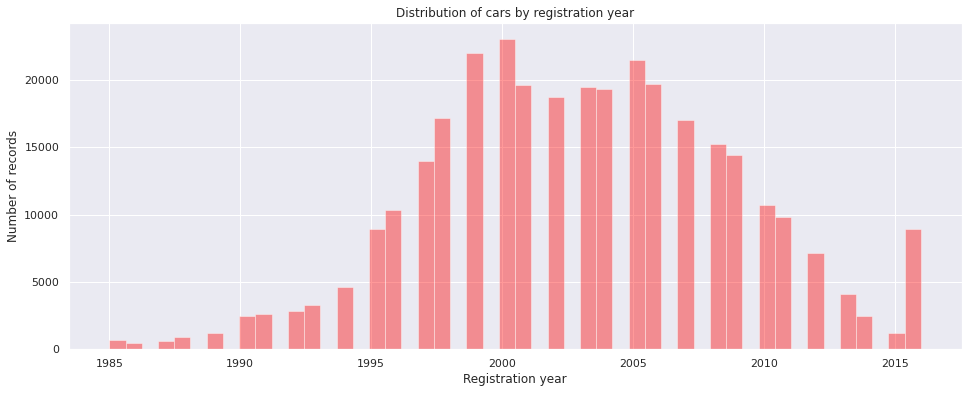

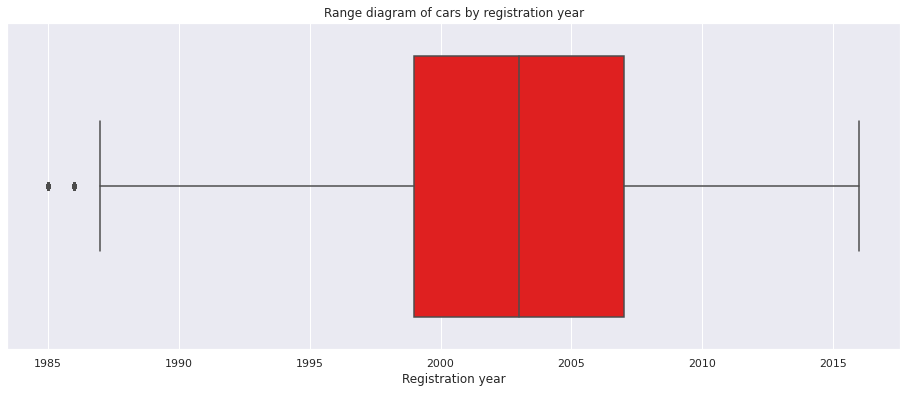

In [32]:
data = data.query('1985 <= registration_year <= 2016')
data.reset_index(drop=True).head()

draw_histogram(data, 
               'registration_year', 
               'Distribution of cars by registration year', 
               xlabel='Registration year', 
               ylabel='Number of records')

draw_boxplot(data, 
             'registration_year', 
             'Range diagram of cars by registration year', 
             xlabel='Registration year')

Finally, we will correct the year of car registration from 1985 to 2016.

Next

### Anomalies and errors in the power column - power.

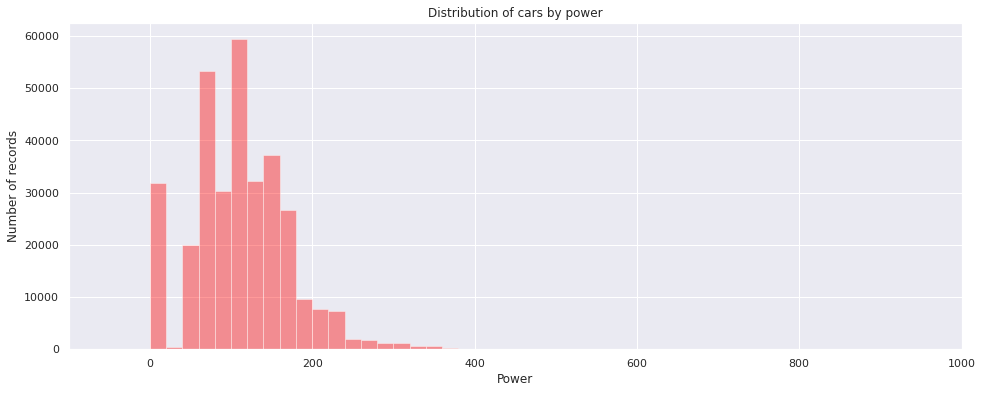

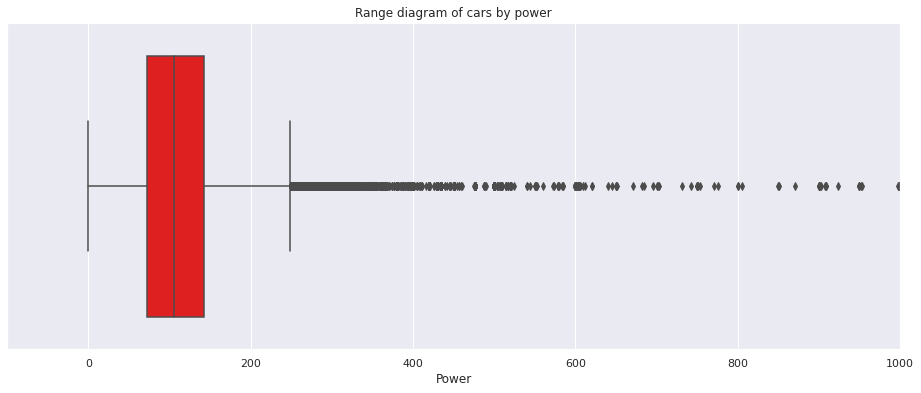

In [33]:
draw_histogram(data, 
               'power', 
               'Distribution of cars by power', 
               xlabel='Power', 
               ylabel='Number of records', 
               xlim=(-100,1000), 
               bins=1000)

draw_boxplot(data, 
             'power', 
             'Range diagram of cars by power', 
             xlim=(-100,1000), 
             xlabel='Power')

From the data above and the graph, we can see that there are data with power close to zero.

Let's take a closer look at the data first within the range up to 100 hp.

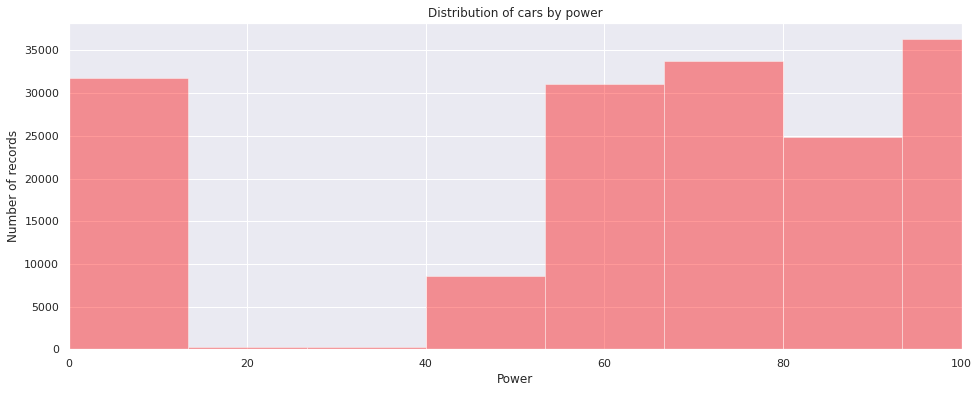

In [34]:
draw_histogram(data, 
               'power', 
               'Distribution of cars by power',
               xlabel='Power', 
               ylabel='Number of records', 
               xlim=(0,100), 
               bins=1500)

Let's take a closer look. Let's take a closer look at the data within the range of 300 to 400 hp.

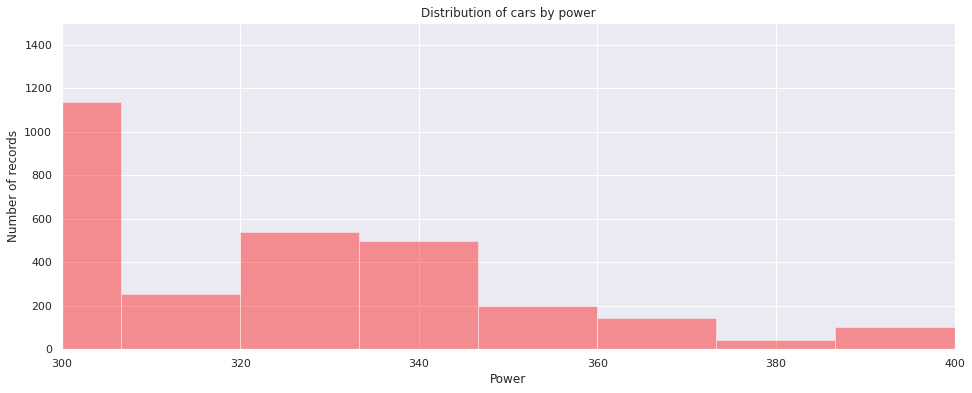

In [35]:
draw_histogram(data, 
               'power', 
               'Distribution of cars by power', 
               xlabel='Power', 
               ylabel='Number of records', 
               xlim=(300,400), 
               ylim=(0,1500), 
               bins=1500)

As we can see, the most adequate range of power is from 40 to 400.

In [36]:
data = data.query('40 <= power <= 400')
data.reset_index(drop=True).head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291781 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       291781 non-null  object
 1   gearbox            291781 non-null  object
 2   power              291781 non-null  int64 
 3   kilometer          291781 non-null  int64 
 4   fuel_type          291781 non-null  object
 5   brand              291781 non-null  object
 6   not_repaired       291781 non-null  object
 7   registration_year  291781 non-null  int64 
 8   model              291781 non-null  object
 9   price              291781 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 24.5+ MB


### Anomalies and errors in the kilometer column - mileage.

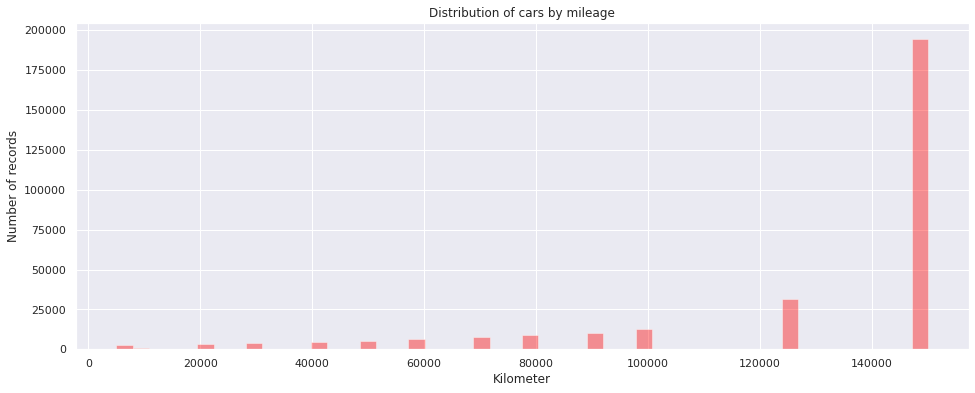

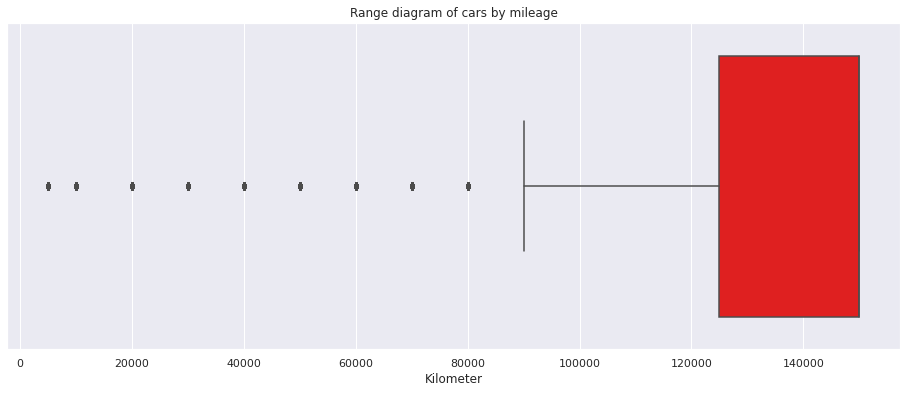

In [37]:
draw_histogram(data, 
               'kilometer', 
               'Distribution of cars by mileage', 
               xlabel='Kilometer', 
               ylabel='Number of records', 
               bins=50)

draw_boxplot(data, 
             'kilometer', 
             'Range diagram of cars by mileage', 
             xlabel='Kilometer')

We will replace the gearbox and not_repaired columns with a Boolean type.

In [38]:
data['is_manual_gearbox'] = 0
data.loc[data['gearbox'] == 'manual', 'is_manual_gearbox'] = 1
display(data['is_manual_gearbox'].value_counts())
data['gearbox'].value_counts()

1    228995
0     62786
Name: is_manual_gearbox, dtype: int64

manual     228995
auto        57612
unknown      5174
Name: gearbox, dtype: int64

In [39]:
data['is_not_repaired'] = 0
data.loc[data['not_repaired'] == 'yes', 'is_not_repaired'] = 1
display(data['is_not_repaired'].value_counts())
data['not_repaired'].value_counts()

0    263314
1     28467
Name: is_not_repaired, dtype: int64

no         221345
unknown     41969
yes         28467
Name: not_repaired, dtype: int64

In [40]:
data.drop(['not_repaired','gearbox'], 
          inplace=True, 
          axis=1)

#### To save memory, we will change the data type and thus speed up the model training.

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291781 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       291781 non-null  object
 1   power              291781 non-null  int64 
 2   kilometer          291781 non-null  int64 
 3   fuel_type          291781 non-null  object
 4   brand              291781 non-null  object
 5   registration_year  291781 non-null  int64 
 6   model              291781 non-null  object
 7   price              291781 non-null  int64 
 8   is_manual_gearbox  291781 non-null  int64 
 9   is_not_repaired    291781 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 24.5+ MB


In [42]:
data['is_not_repaired'] = pd.to_numeric(data['is_not_repaired'], downcast='integer')
data['is_manual_gearbox'] = pd.to_numeric(data['is_manual_gearbox'], downcast='integer')
data['registration_year'] = pd.to_numeric(data['registration_year'], downcast='integer')
data['power'] = pd.to_numeric(data['power'], downcast='integer')
data['kilometer'] = pd.to_numeric(data['kilometer'], downcast='integer')
data['price'] = pd.to_numeric(data['price'], downcast='integer')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291781 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       291781 non-null  object
 1   power              291781 non-null  int16 
 2   kilometer          291781 non-null  int32 
 3   fuel_type          291781 non-null  object
 4   brand              291781 non-null  object
 5   registration_year  291781 non-null  int16 
 6   model              291781 non-null  object
 7   price              291781 non-null  int16 
 8   is_manual_gearbox  291781 non-null  int8  
 9   is_not_repaired    291781 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 14.5+ MB


Let's look at the result of the data transformation.

In [43]:
print('Memory usage reduction by {:.2%}'.format(1 - 15.0/25.3))

Memory usage reduction by 40.71%


No anomalies and errors with mileage data.

Conclusion: 

During the loading and review of the data, a dataset of 354365x16 was provided. 
* Upon approximate consideration, duplicates were found in the amount of 4 pieces - duplicates were removed; 
* Non-informative columns were removed from the dataset and the names were brought to lower case; 
From the detailed review of the data, missing data and anomalous values were identified: 
  - Missing data in categorical data were filled with unknown as it is not possible to fill in with average or median values; 
  - Anomalies and errors were identified in the power, registration_year, and price columns, with the power data limited to 40-400 hp, the registration_year data limited to 1985-2021, and the price data with zero values removed; 
  - No anomalies or errors were identified in the mileage column. 
* Data transformation was performed, with a 40.71% reduction in memory usage. 
* Categorical data in the not_repaired and gearbox columns were replaced with Boolean type.

## 2. Encoding data.


Let's choose the following regressors for training the model:
* LinearRegression
* Ridge
* DecisionTreeRegressor
* CatBoostRegressor
* LGBMRegressor

As a metric for all models, we will use MSE and convert it to RMSE in the final table. We will check the quality of the models using cross-validation. 

We will prepare three types of features for cross-validation: 
* Unmodified. Name: original_features. 
* Encoded by OHE method. Name: ohe_features. 
* Encoded by OE method. Name: ordinal_features.

In [44]:
original_features = data.drop('price', 
                              axis=1)

encoder = OrdinalEncoder()

cat_columns = ['vehicle_type',
               'fuel_type',
               'brand',
               'model']

cat_features = original_features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                            columns=cat_features.columns,
                            index=cat_features.index)

ordinal_features = original_features.copy()

for column in cat_columns:
    ordinal_features[column] = cat_features[column]

ohe_features = pd.get_dummies(original_features, 
                              drop_first=True)

target = data['price']

In [45]:
original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, 
    target, 
    test_size=0.25, 
    random_state=12345)

ordinal_features_train = ordinal_features.loc[original_features_train.index, :]
ordinal_features_test = ordinal_features.loc[original_features_test.index, :]

ohe_features_train = ohe_features.loc[original_features_train.index, :]
ohe_features_test = ohe_features.loc[original_features_test.index, :]

## 3. Training models.

### LinearRegression.

In [46]:
%%time

start_time = time.time()

regressor = LinearRegression()

cv_RMSE_LR = (cross_val_score(regressor,
                              ohe_features_train, 
                              target_train, 
                              cv=5, 
                              scoring='neg_mean_squared_error'
                              ).mean() * -1) ** 0.5
                              
print('RMSE =', round(cv_RMSE_LR, 2))

cv_lt_LR  = time.time() - start_time
cv_lt_LR

RMSE = 2360.25
CPU times: user 57.2 s, sys: 7.5 s, total: 1min 4s
Wall time: 44.7 s


44.72357106208801

Linear regression with scaled features.

In [47]:
%%time

regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),
                     ("linear_regression", regressor)])

cv_RMSE_LR_S = (cross_val_score(pipeline,
                                ohe_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error'
                                ).mean() * -1) ** 0.5

print('RMSE =', round(cv_RMSE_LR_S, 2))

RMSE = 2360.25
CPU times: user 1min, sys: 9.67 s, total: 1min 10s
Wall time: 51.7 s


Scaling the features is not significant, but it worsens the model. We will refrain from using scaling.

### Ridge regression.

In [48]:
%%time

start_time = time.time()

regressor = Ridge()
hyperparams = [{'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]

clf = GridSearchCV(regressor, 
                   hyperparams, 
                   scoring='neg_mean_squared_error')

clf.fit(ohe_features_train, target_train)

print('Best hyperparameters:')
print()
print(clf.best_params_)
print()
print('RMSE for hiperparameters:')
print()

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print('%0.6f for %r'% ((mean*-1)** 0.5, params))
print()

cv_RMSE_R = (max(means)*-1) ** 0.5
print('RMSE =', round(cv_RMSE_R, 2))

cv_lt_R  = time.time() - start_time
cv_lt_R

Best hyperparameters:

{'solver': 'auto'}

RMSE for hiperparameters:

2360.177062 for {'solver': 'auto'}
2360.177062 for {'solver': 'svd'}
2360.177062 for {'solver': 'cholesky'}
3348.398422 for {'solver': 'lsqr'}
2869.400590 for {'solver': 'sparse_cg'}

RMSE = 2360.18
CPU times: user 2min 9s, sys: 20.3 s, total: 2min 29s
Wall time: 1min 39s


99.94395852088928

### DecisionTreeRegressor.

Let's perform two experiments: 
* We will test the model on features encoded by the OHE method. 
* On features encoded by the OE method.

In [49]:
%%time

start_time = time.time()

regressor = DecisionTreeRegressor()
max_depth_list = [x for x in range(2, 31)]

hyperparams = [{'criterion':['squared_error'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, 
                   hyperparams, 
                   scoring='neg_mean_squared_error')

clf.fit(ohe_features_train, target_train)

print('Best hyperparameters:')
print()
print(clf.best_params_)
print()
print('RMSE for hiperparameters:')
print()

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print('%0.6f for %r'% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ohe = (max(means)*-1) ** 0.5
print('RMSE =', round(cv_RMSE_DTR_ohe, 2))

cv_lt_DTR_ohe  = time.time() - start_time
cv_lt_DTR_ohe

Best hyperparameters:

{'criterion': 'squared_error', 'max_depth': 19, 'random_state': 12345}

RMSE for hiperparameters:

3119.988825 for {'criterion': 'squared_error', 'max_depth': 2, 'random_state': 12345}
2833.998554 for {'criterion': 'squared_error', 'max_depth': 3, 'random_state': 12345}
2516.348661 for {'criterion': 'squared_error', 'max_depth': 4, 'random_state': 12345}
2338.993330 for {'criterion': 'squared_error', 'max_depth': 5, 'random_state': 12345}
2189.578775 for {'criterion': 'squared_error', 'max_depth': 6, 'random_state': 12345}
2096.906245 for {'criterion': 'squared_error', 'max_depth': 7, 'random_state': 12345}
2012.538201 for {'criterion': 'squared_error', 'max_depth': 8, 'random_state': 12345}
1956.829088 for {'criterion': 'squared_error', 'max_depth': 9, 'random_state': 12345}
1909.504169 for {'criterion': 'squared_error', 'max_depth': 10, 'random_state': 12345}
1864.517987 for {'criterion': 'squared_error', 'max_depth': 11, 'random_state': 12345}
1827.905817 for 

718.5460839271545

In [50]:
%%time

start_time = time.time()

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]

hyperparams = [{'criterion':['squared_error'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, 
                   hyperparams, 
                   scoring='neg_mean_squared_error')

clf.fit(ordinal_features_train, target_train)

print('Best hyperparameters:')
print()
print(clf.best_params_)
print()
print('RMSE for hiperparameters:')
print()

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ordinal = (max(means)*-1) ** 0.5
print('RMSE =', round(cv_RMSE_DTR_ordinal, 2))

cv_lt_DTR_ordinal  = time.time() - start_time
cv_lt_DTR_ordinal

Best hyperparameters:

{'criterion': 'squared_error', 'max_depth': 15, 'random_state': 12345}

RMSE for hiperparameters:

3119.988825 for {'criterion': 'squared_error', 'max_depth': 2, 'random_state': 12345}
2833.998554 for {'criterion': 'squared_error', 'max_depth': 3, 'random_state': 12345}
2514.162567 for {'criterion': 'squared_error', 'max_depth': 4, 'random_state': 12345}
2334.808554 for {'criterion': 'squared_error', 'max_depth': 5, 'random_state': 12345}
2194.065218 for {'criterion': 'squared_error', 'max_depth': 6, 'random_state': 12345}
2096.411179 for {'criterion': 'squared_error', 'max_depth': 7, 'random_state': 12345}
2019.089438 for {'criterion': 'squared_error', 'max_depth': 8, 'random_state': 12345}
1953.067336 for {'criterion': 'squared_error', 'max_depth': 9, 'random_state': 12345}
1902.587855 for {'criterion': 'squared_error', 'max_depth': 10, 'random_state': 12345}
1854.344964 for {'criterion': 'squared_error', 'max_depth': 11, 'random_state': 12345}
1822.206819 for 

82.80600571632385

### CatBoostRegressor.

Let's conduct two experiments.
* Train a model on data encoded using the OE method.
* Train on original data with specified categories.

In [51]:
%%time

start_time = time.time()

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[12345],
                'verbose':[False]}]

clf = GridSearchCV(regressor, 
                   hyperparams, 
                   scoring='neg_mean_squared_error')

clf.fit(ordinal_features_train, target_train)

print('Best hyperparameters:')
print()
print(clf.best_params_)
print()
print('RMSE for hiperparameters:')
print()

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print('%0.6f for %r'% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5
print('RMSE =', round(cv_RMSE_CBR_ordinal, 2))

cv_lt_CBR_ordinal  = time.time() - start_time
cv_lt_CBR_ordinal

Best hyperparameters:

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}

RMSE for hiperparameters:

1544.407420 for {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
1510.557739 for {'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
1527.865072 for {'learning_rate': 0.8, 'random_state': 12345, 'verbose': False}

RMSE = 1510.56
CPU times: user 12min 16s, sys: 32.8 s, total: 12min 49s
Wall time: 7min 24s


444.62562227249146

In [52]:
%%time

start_time = time.time()

regressor = CatBoostRegressor(learning_rate=0.5,
                              iterations = 200,
                              random_state=12345, 
                              verbose=False, 
                              cat_features=['vehicle_type','fuel_type','brand','model']) 

cv_RMSE_CBR_original = (cross_val_score(regressor,
                                        original_features_train, 
                                        target_train,
                                        cv=5, 
                                        scoring='neg_mean_squared_error'
                                        ).mean() * -1) ** 0.5
                                        
print('RMSE =', round(cv_RMSE_CBR_original, 2))

cv_lt_CBR_original  = time.time() - start_time
cv_lt_CBR_original

RMSE = 1560.49
CPU times: user 4min 6s, sys: 3.49 s, total: 4min 10s
Wall time: 2min 26s


146.99048328399658

### LGBMRegressor.

In [53]:
%%time

start_time = time.time()

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[12345]}]

clf = GridSearchCV(regressor, 
                   hyperparams, 
                   scoring='neg_mean_squared_error')

clf.fit(ordinal_features_train, target_train)

print('Best hyperparameters:')
print()
print(clf.best_params_)
print()
print('RMSE for hiperparameters:')
print()

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print('%0.6f for %r'% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5
print('RMSE =', round(cv_RMSE_LGBMR, 2))

cv_lt_LGBMR  = time.time() - start_time
cv_lt_LGBMR

Best hyperparameters:

{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}

RMSE for hiperparameters:

1634.650561 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 12345}
1541.890285 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 12345}
1505.395749 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}
1567.380660 for {'learning_rate': 0.3, 'num_leaves': 31, 'random_state': 12345}
1509.870348 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 12345}
1493.348753 for {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}
1559.284815 for {'learning_rate': 0.5, 'num_leaves': 31, 'random_state': 12345}
1523.611869 for {'learning_rate': 0.5, 'num_leaves': 100, 'random_state': 12345}
1516.997240 for {'learning_rate': 0.5, 'num_leaves': 200, 'random_state': 12345}

RMSE = 1493.35
CPU times: user 3min 5s, sys: 2.9 s, total: 3min 8s
Wall time: 1min 53s


113.79572677612305

## 4. Model analysis.

We will train each model with the best hyperparameters.

### LinearRegression.

In [54]:
%%time

start_time = time.time()

model = LinearRegression()
model.fit(ohe_features_train, target_train)

lt_LR  = time.time() - start_time
lt_LR

CPU times: user 14.4 s, sys: 2.2 s, total: 16.6 s
Wall time: 10.9 s


10.91646122932434

In [55]:
%%time

start_time = time.time()

target_predict = model.predict(ohe_features_train)

pt_LR  = time.time() - start_time
pt_LR

CPU times: user 314 ms, sys: 220 ms, total: 534 ms
Wall time: 450 ms


0.44963908195495605

In [56]:
final_RMSE_LR = mean_squared_error(target_train, target_predict) ** 0.5

### Ridge.

In [57]:
%%time

start_time = time.time()

model = Ridge(solver='svd')
model.fit(ohe_features_train, target_train)

lt_R  = time.time() - start_time
lt_R

CPU times: user 22.5 s, sys: 2.45 s, total: 24.9 s
Wall time: 15.1 s


15.074637413024902

In [58]:
%%time

start_time = time.time()

target_predict = model.predict(ohe_features_train)

pt_R  = time.time() - start_time
pt_R

CPU times: user 344 ms, sys: 246 ms, total: 590 ms
Wall time: 471 ms


0.4710958003997803

In [59]:
final_RMSE_R = mean_squared_error(target_train, target_predict) ** 0.5

### DecisionTreeRegressor.

In [60]:
%%time

start_time = time.time()

model = DecisionTreeRegressor(criterion='squared_error', 
                              max_depth=15, 
                              random_state=12345)
 
model.fit(ohe_features_train, target_train)

lt_DTR_ohe  = time.time() - start_time
lt_DTR_ohe

CPU times: user 6.45 s, sys: 173 ms, total: 6.63 s
Wall time: 6.62 s


6.62150764465332

In [61]:
%%time

start_time = time.time()

target_predict = model.predict(ohe_features_train)

pt_DTR_ohe  = time.time() - start_time
pt_DTR_ohe

CPU times: user 144 ms, sys: 99.8 ms, total: 244 ms
Wall time: 244 ms


0.2438950538635254

In [62]:
final_RMSE_DTR_ohe = mean_squared_error(target_train, target_predict) ** 0.5 

In [63]:
%%time

start_time = time.time()

model = DecisionTreeRegressor(criterion='squared_error', 
                              max_depth=13, 
                              random_state=12345) 

model.fit(ordinal_features_train, target_train)

lt_DTR_ordinal  = time.time() - start_time
lt_DTR_ordinal

CPU times: user 681 ms, sys: 1.08 ms, total: 682 ms
Wall time: 693 ms


0.6926167011260986

In [64]:
%%time

start_time = time.time()

target_predict = model.predict(ordinal_features_train)

pt_DTR_ordinal  = time.time() - start_time
pt_DTR_ordinal

CPU times: user 48.6 ms, sys: 0 ns, total: 48.6 ms
Wall time: 54.3 ms


0.05417799949645996

In [65]:
final_RMSE_DTR_ordinal = mean_squared_error(target_train, target_predict) ** 0.5

### CatBoostRegressor.

In [66]:
%%time

start_time = time.time()

model = CatBoostRegressor(learning_rate=0.5, 
                          random_state=12345, 
                          verbose=False) 

model.fit(ordinal_features_train, target_train)

lt_CBR_ordinal = time.time() - start_time
lt_CBR_ordinal

CPU times: user 56.4 s, sys: 2.75 s, total: 59.1 s
Wall time: 36.4 s


36.3613817691803

In [67]:
%%time

start_time = time.time()

target_predict = model.predict(ordinal_features_train)

pt_CBR_ordinal = time.time() - start_time
pt_CBR_ordinal

CPU times: user 442 ms, sys: 9.74 ms, total: 452 ms
Wall time: 254 ms


0.2536592483520508

In [68]:
final_RMSE_CBR_ordinal = mean_squared_error(target_train, target_predict) ** 0.5

In [69]:
%%time

start_time = time.time()

model = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 200, 
                          random_state=12345, 
                          verbose=False,
                          cat_features=['vehicle_type','fuel_type','brand','model']) 

model.fit(original_features_train, target_train)

lt_CBR_original = time.time() - start_time
lt_CBR_original

CPU times: user 1min 2s, sys: 612 ms, total: 1min 3s
Wall time: 38.8 s


38.76976227760315

In [70]:
%%time

start_time = time.time()

target_predict = model.predict(original_features_train)

pt_CBR_original = time.time() - start_time
pt_CBR_original

CPU times: user 808 ms, sys: 7.05 ms, total: 815 ms
Wall time: 512 ms


0.5123124122619629

In [71]:
final_RMSE_CBR_original = mean_squared_error(target_train, target_predict) ** 0.5

### LGBMRegressor.

In [72]:
%%time

start_time = time.time()

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=12345)

model.fit(ordinal_features_train, target_train)

lt_LGBMR = time.time() - start_time
lt_LGBMR

CPU times: user 5.93 s, sys: 113 ms, total: 6.04 s
Wall time: 3.23 s


3.2320868968963623

In [73]:
%%time

start_time = time.time()

target_predict = model.predict(ordinal_features_train)

pt_LGBMR = time.time() - start_time
pt_LGBMR

CPU times: user 2.85 s, sys: 3.32 ms, total: 2.85 s
Wall time: 1.56 s


1.5562477111816406

In [74]:
final_RMSE_LGBMR = mean_squared_error(target_train, target_predict) ** 0.5

### Let's compare the models.

We will compare the models and summarize the data in a table for comparison of parameters.

In [75]:
index = ['LinearRegression',
         'Ridge',
         'DecisionTreeRegressor on OHE features',
         'DecisionTreeRegressor on OE features',
         'CatBoostRegressor on OE features',
         'CatBoostRegressor on original features',
         'LGBMRegressor']
         
data = {'CV RMSE, eur':[cv_RMSE_LR,
                        cv_RMSE_R,
                        cv_RMSE_DTR_ohe,
                        cv_RMSE_DTR_ordinal,
                        cv_RMSE_CBR_ordinal,
                        cv_RMSE_CBR_original,
                        cv_RMSE_LGBMR],
        'CV learning time, sec':[cv_lt_LR,
                                 cv_lt_R,
                                 cv_lt_DTR_ohe,
                                 cv_lt_DTR_ordinal,
                                 cv_lt_CBR_ordinal,
                                 cv_lt_CBR_original,
                                 cv_lt_LGBMR],
        'RMSE of model, eur':[final_RMSE_LR,
                              final_RMSE_R,
                              final_RMSE_DTR_ohe,
                              final_RMSE_DTR_ordinal,
                              final_RMSE_CBR_ordinal,
                              final_RMSE_CBR_original,
                              final_RMSE_LGBMR],
        'Model learning time, sec':[lt_LR,
                                    lt_R,
                                    lt_DTR_ohe,
                                    lt_DTR_ordinal,
                                    lt_CBR_ordinal,
                                    lt_CBR_original,
                                    lt_LGBMR],
        'Prediction time, sec':[pt_LR,
                                pt_R,
                                pt_DTR_ohe,
                                pt_DTR_ordinal,
                                pt_CBR_ordinal,
                                pt_CBR_original,
                                pt_LGBMR]}

scores_data = pd.DataFrame(data=data, 
                           index=index)

scores_data['Raiting of RMSE'] = (scores_data['CV RMSE, eur'].min() /
                              scores_data['CV RMSE, eur'])

scores_data['Raiting of learning time'] = (scores_data['Model learning time, sec'].min() / 
                              scores_data['Model learning time, sec'])

scores_data['Raiting of prediction time'] = (scores_data['Prediction time, sec'].min() / 
                              scores_data['Prediction time, sec'])

scores_data['Final raiting'] = (scores_data['Raiting of RMSE'] +
                                   scores_data['Raiting of learning time'] +
                                   scores_data['Raiting of prediction time'])

scores_data

,"CV RMSE, eur","CV learning time, sec","RMSE of model, eur","Model learning time, sec","Prediction time, sec",Raiting of RMSE,Raiting of learning time,Raiting of prediction time,Final raiting
LinearRegression,"2,360.25",44.72,"2,356.11",10.92,0.45,0.63,0.06,0.12,0.82
Ridge,"2,360.18",99.94,"2,356.17",15.07,0.47,0.63,0.05,0.12,0.79
DecisionTreeRegressor on OHE features,"1,744.64",718.55,"1,482.53",6.62,0.24,0.86,0.10,0.22,1.18
DecisionTreeRegressor on OE features,"1,786.51",82.81,"1,553.31",0.69,0.05,0.84,1.00,1.00,2.84
CatBoostRegressor on OE features,"1,510.56",444.63,"1,325.91",36.36,0.25,0.99,0.02,0.21,1.22
CatBoostRegressor on original features,"1,560.49",146.99,"1,496.62",38.77,0.51,0.96,0.02,0.11,1.08
LGBMRegressor,"1,493.35",113.80,"1,394.59",3.23,1.56,1.00,0.21,0.03,1.25


### 5. Testing model.

In [76]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 942 ms, sys: 1 ms, total: 943 ms
Wall time: 498 ms


In [77]:
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5
print(final_RMSE_LGBMR)

1537.501178597746


## 6. Overall conclusion:

During the loading and review of the data, we were provided with a dataset of 354365x16. 
* Upon approximate consideration, duplicates were found in the amount of 4 pieces - duplicates were removed; 
* Non-informative columns were removed from the dataset, and the names were brought to lower case; 
* From the detailed review of the data, missing data and anomalous values were identified: 
  * missing data in categorical data were filled with unknown as it is impossible to fill with average or median values; 
  * anomalies and errors in the mileage column were not identified; 
* Data transformation was performed, during which the memory usage was reduced by 40.71%. 
* Categorical data in the not_repaired and gearbox columns were replaced with Boolean type.

As we can see from the results, CatBoostRegressor and LGBMRegressor lead in terms of accuracy. 

The models studied in terms of accuracy can be grouped into the following categories:
* High accuracy models - CatBoostRegressor and LGBMRegressor;
* Medium accuracy model - DecisionTreeRegressor;
* Low accuracy models - LinearRegression and Ridge.

In terms of speed of work: the minimum training time and prediction time for the DecisionTreeRegressor model on OE features, but the accuracy lags behind the leader model LGBMRegressor by 17.85%. 

The models studied in terms of speed can be grouped into the following categories: 
* High speed, model - DecisionTreeRegressor;
* Medium speed, model - LGBMRegressor;
* Low speed, models - LinearRegression, Ridge and CatBoostRegressor.

Based on the criteria that are important to the customer and the fact that the quality of prediction is first, the training time of the model is second, and the prediction time is third:
* Quality of prediction;
* Training time of the model;
* Prediction time of the model.


It is clear that the customer can be recommended to pay attention to the exact LGBMRegressor model with an average speed category. 

To confirm the choice of the LGBMR model as the best for solving the task, the metric on the test sample confirms this choice, showing the RMSE metric 1394.59, the learning time 3.23 seconds and the prediction time 1.56 seconds.